## Chapter 3 -  End-to-End Machine Learning Project
## Load Data

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix, f1_score, 
                             precision_recall_curve)
from sklearn.base import BaseEstimator

def load(fname):
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

### Ingest

In [2]:
mnist_data = load('mnist.data.pkl')
X, y = mnist_data['data'], mnist_data['target']

In [3]:
# # For testing. Note that 28*28 = 784
# print(X.shape)
# print(y.shape)

In [4]:
# # For testing
# sample_idk = 4
# d_single_sample = X[sample_idk]
# print(d_single_sample)
# d_single_sample_img = d_single_sample.reshape(28, 28)
# print(d_single_sample)
# plt.imshow(d_single_sample_img, cmap=matplotlib.cm.binary, interpolation='nearest')
# plt.axis('off')
# plt.show()
# print(y[sample_idk])

Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [6]:
# # For testing
# display(pd.DataFrame({'train' : pd.Series(y_train).value_counts()/len(y_train)*100,
#                     'test' : pd.Series(y_test).value_counts()/len(y_test)*100}))

Binary Classifier

In [7]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
# Create model, train & evaluate
sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
kfold = 3
cvs1 = cross_val_score(estimator=sgd_clf, X=X_test, y=y_test_5, cv=kfold)
print(cvs1, cvs1.mean(), cvs1.std())

[0.94285714 0.92371429 0.96028571] 0.9422857142857143 0.014935689804356977


It shows that the estimator gives a 94% accuracy, very good! Now compare this with the dummy classifier

In [10]:
class Dummy5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
dummy_clf = Dummy5Classifier()
dummy_clf.fit(X_train, y_train)

In [12]:
cvs2 = cross_val_score(estimator=dummy_clf, X=X_test, y=y_test_5, cv=kfold, scoring='accuracy')
print(cvs2, cvs2.mean(), cvs2.std())

[0.91628571 0.91085714 0.90885714] 0.9119999999999999 0.0031385251530065016


Dummy classifier gave a 91% accuracy, which makes sense. If 91% of the images are not 5, then, by using rules, predicting "not 5" alone gives already a high accuracy. Hence, accuracy is generally not preferred as a performance measures when the classifier has skewed datasets.

In [13]:
# cross_val_predict gives the prediction result of each sample when it
# is in the test set group
ypred2 = cross_val_predict(sgd_clf, X_test, y_test_5, cv=3)

Precision is $\frac{TP}{TP+FP}$, of all you predicted class 1, how many were predicted wrongly?

Recall is $\frac{TP}{TP+FN}$, of all samples that are class 1, how many were predicted wrongly?

In [14]:
print(confusion_matrix(y_test_5, ypred2)) # first value takes row, 2nd value takes columns
print(precision_score(y_test_5, ypred2)) 
print(recall_score(y_test_5, ypred2))

[[9118  458]
 [ 148  776]]
0.6288492706645057
0.8398268398268398


F1 score is harmonic mean of Precision & Recall. $$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$A harmonic mean gives more weight to low values. Hence, the classifier will only get a high F1 score if both precision & recall are high.

In [15]:
print(f1_score(y_test_5, ypred2))

0.7191844300278035


In some contexts you prefer better precision, while in others, you prefer higher recall. You cannot have it both ways. A higher precision leads to a lower recall and vice versa. This is called the precision/recall tradeoff.

In [16]:
ypredscores3 = sgd_clf.decision_function(X_test)

In [17]:
# In SGD Classifer, you can access the decision function scores and then decide the prediction result based 
# on a preset threshold
threshold3 = 0
ypred3a = (ypredscores3 > threshold3)

print(confusion_matrix(y_test_5, ypred3a)) 
print(precision_score(y_test_5, ypred3a)) 
print(recall_score(y_test_5, ypred3a))
print(f1_score(y_test_5, ypred3a))

[[9522   54]
 [ 339  585]]
0.9154929577464789
0.6331168831168831
0.7485604606525911


In [18]:
threshold3 = 5000
ypred3b = (ypredscores3 > threshold3)

print(confusion_matrix(y_test_5, ypred3b)) 
print(precision_score(y_test_5, ypred3b)) 
print(recall_score(y_test_5, ypred3b))
print(f1_score(y_test_5, ypred3b))

[[9573    3]
 [ 750  174]]
0.9830508474576272
0.18831168831168832
0.3160762942779292


In [19]:
# Get decision function
y_scores = cross_val_predict(sgd_clf, X_test, y_test_5, cv=3, method='decision_function')

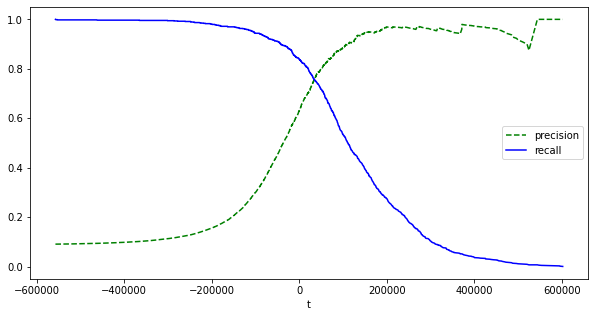

In [20]:
# Plot precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_scores)
prt_df = pd.DataFrame({'precision' : precisions[:-1], 'recall' : recalls[:-1], 't' : thresholds})
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
prt_df.plot(x='t', y='precision', ax=ax, color='green', style='--')
prt_df.plot(x='t', y='recall', ax=ax, color='blue', style='-')